1. Setup & Imports
We will use requests for fetching raw data and seaborn for enhanced visualization.

In [6]:
import requests
import nltk
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.util import ngrams
from collections import Counter

# Download only necessary NLTK datasets
nltk.download('stopwords')

# Setting visual style for plots
sns.set_theme(style="whitegrid")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


2. Data Acquisition (Direct HTTP Request)
Instead of using a wrapper library, we fetch raw text directly from a URL. We will analyze "The Adventures of Sherlock Holmes" to see linguistic patterns in literature.

In [7]:
def fetch_text_from_url(url):
    """
    Fetches raw text content from a given URL using HTTP GET request.
    """
    response = requests.get(url)
    if response.status_code == 200:
        print("Success: Data fetched successfully.")
        return response.text
    else:
        print(f"Error: Unable to fetch data. Status code: {response.status_code}")
        return ""

# URL for Project Gutenberg (Sherlock Holmes raw text file)
target_url = "https://www.gutenberg.org/files/1661/1661-0.txt"

# Get the raw string data
raw_data = fetch_text_from_url(target_url)

# Let's inspect the first 500 characters
print(f"\nSample raw text:\n{raw_data[0:1500]}")

Success: Data fetched successfully.

Sample raw text:
﻿The Project Gutenberg eBook of The Adventures of Sherlock Holmes,
by Arthur Conan Doyle

This eBook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this eBook or online at
www.gutenberg.org. If you are not located in the United States, you
will have to check the laws of the country where you are located before
using this eBook.

Title: The Adventures of Sherlock Holmes

Author: Arthur Conan Doyle

Release Date: November 29, 2002 [eBook #1661]
[Most recently updated: October 10, 2023]

Language: English

Character set encoding: UTF-8

Produced by: an anonymous Project Gutenberg volunteer and Jose Menendez

*** START OF THE PROJECT GUTENBERG EBOOK THE ADVENTURES OF SHERLOCK
HOLMES ***




The Adventures of Sherlock Holmes

by Arthur Co

3. Advanced Preprocessing Pipeline
Here we use RegexpTokenizer. It is structurally different from re.sub because it selects what we want (words) rather than removing what we don't want. This eliminates punctuation automatically.

In [8]:
def process_corpus(text_data):
    """
    Cleans and tokenizes the full text corpus.
    Steps:
    1. Tokenize using Regex (keeps only words, removes punctuation implicitly).
    2. Lowercase conversion.
    3. Stopword removal.
    4. Stemming (PorterStemmer) - reduces words to root form (e.g., 'running' -> 'run').
    """
    # 1. Initialize tokenizer to pick only alphanumeric words
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text_data)

    # 2. Convert to lowercase
    tokens = [t.lower() for t in tokens]

    # 3. Filter out stopwords (common words like 'the', 'is', 'in')
    stop_words = set(stopwords.words('english'))
    # Adding some book-specific artifacts to stopwords if needed
    custom_stops = {'gutenberg', 'project', 'ebook', 'chapter'}
    stop_words.update(custom_stops)

    filtered_tokens = [t for t in tokens if t not in stop_words and len(t) > 2]

    # 4. Stemming (optional step, makes it distinct from Lemmatization in the original)
    stemmer = PorterStemmer()
    processed_tokens = [stemmer.stem(t) for t in filtered_tokens]

    return processed_tokens

# Execution
print("Processing corpus... This may take a moment.")
clean_tokens = process_corpus(raw_data)

print(f"Total tokens processed: {len(clean_tokens)}")
print(f"First 10 tokens: {clean_tokens[:10]}")

Processing corpus... This may take a moment.
Total tokens processed: 47753
First 10 tokens: ['adventur', 'sherlock', 'holm', 'arthur', 'conan', 'doyl', 'use', 'anyon', 'anywher', 'unit']


4. N-Gram Extraction using NLTK Utilities
Instead of writing a manual loop function (as in the original file), we utilize nltk.util.ngrams. This is the Pythonic way to handle sequences.

In [9]:
def analyze_patterns(tokens, n=1, limit=10):
    """
    Generates N-Grams and returns the most common patterns in a DataFrame.
    """
    # Using NLTK's built-in generator
    n_gram_sequences = list(ngrams(tokens, n))

    # Counting frequencies
    frequency_dist = Counter(n_gram_sequences)

    # Preparing data for visualization
    common_items = frequency_dist.most_common(limit)

    # Convert keys from tuples ('holmes',) to strings "holmes"
    labels = [' '.join(item[0]) for item in common_items]
    counts = [item[1] for item in common_items]

    return pd.DataFrame({'Phrase': labels, 'Count': counts})

# Generating statistics
df_unigrams = analyze_patterns(clean_tokens, n=1)
df_bigrams = analyze_patterns(clean_tokens, n=2)
df_trigrams = analyze_patterns(clean_tokens, n=3)

print("--- Bigram Analysis ---\n", df_bigrams)

--- Bigram Analysis ---
           Phrase  Count
0      said holm    114
1  sherlock holm    101
2      could see     31
3   baker street     29
4     young ladi     28
5     lord simon     28
6  electron work     27
7       red head     24
8      upon tabl     20
9    miss hunter     19


5. Visualization with Seaborn
Using seaborn creates a distinct visual style compared to standard matplotlib.

/tmp/ipython-input-1131130637.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.barplot(data=df, x="Count", y="Phrase", palette=palette)


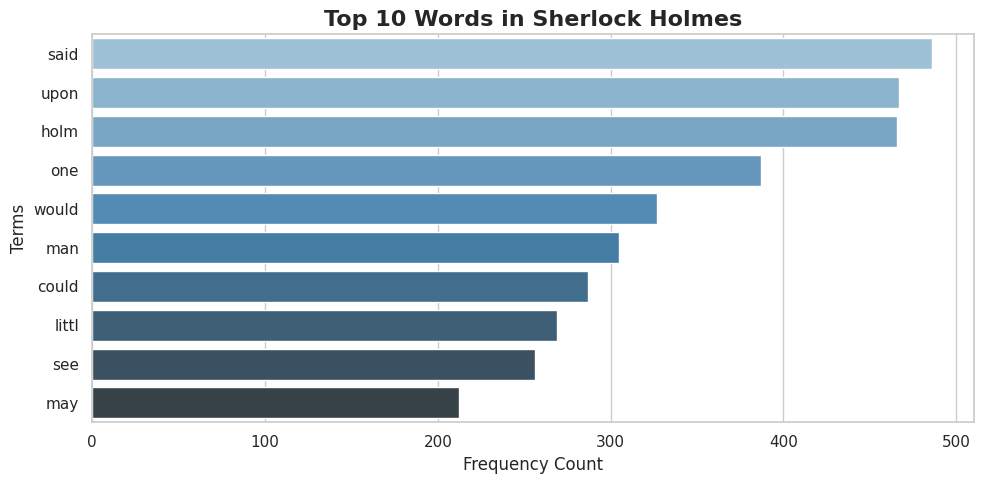

/tmp/ipython-input-1131130637.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.barplot(data=df, x="Count", y="Phrase", palette=palette)


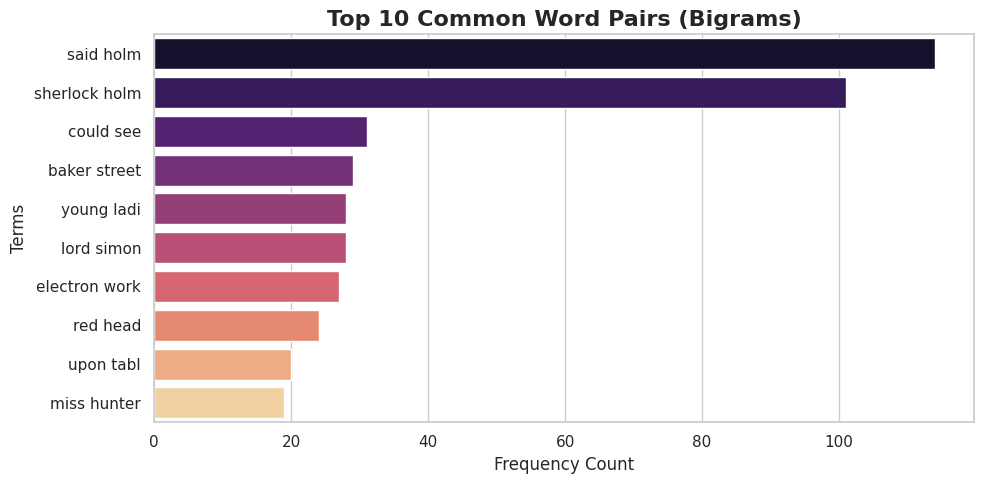

/tmp/ipython-input-1131130637.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  chart = sns.barplot(data=df, x="Count", y="Phrase", palette=palette)


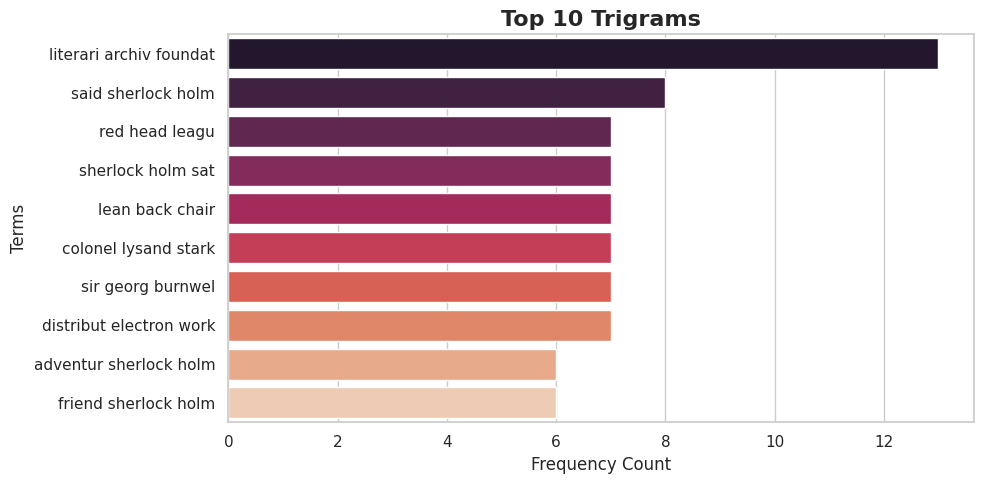

In [10]:
def visualize_frequency(df, title, palette="viridis"):
    """
    Plots a horizontal bar chart using Seaborn.
    """
    plt.figure(figsize=(10, 5))

    # Seaborn barplot
    chart = sns.barplot(data=df, x="Count", y="Phrase", palette=palette)

    chart.set_title(title, fontsize=16, fontweight='bold')
    chart.set_xlabel("Frequency Count", fontsize=12)
    chart.set_ylabel("Terms", fontsize=12)

    plt.tight_layout()
    plt.show()

# Visualizing results
visualize_frequency(df_unigrams, "Top 10 Words in Sherlock Holmes", palette="Blues_d")
visualize_frequency(df_bigrams, "Top 10 Common Word Pairs (Bigrams)", palette="magma")
visualize_frequency(df_trigrams, "Top 10 Trigrams", palette="rocket")